In [1]:
from collections import defaultdict
import numpy as np
from string import punctuation
import pylab as plt
import pandas as pd


import nltk
# nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
%matplotlib inline

mystopwords = set(stopwords.words('english'))
stemmer = nltk.stem.snowball.EnglishStemmer()




[nltk_data] Downloading package stopwords to
[nltk_data]     /home/javiergb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
mystopwords = mystopwords | {"hmmm","hmm","mm","ummm","umm","mmm","uhm","ehm","um"}

In [183]:
import re, math
from collections import Counter

WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
    if isinstance(vec1,str):
        vec1 = Counter(WORD.findall(vec1))
        vec2 = Counter(WORD.findall(vec2))
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [184]:
def jaccard(str1, str2):
    str1 = set(str1.split())
    str2 = set(str2.split())
    return float(len(str1 & str2)) / len(str1 | str2)


In [185]:
def get_between(chains=[3,4],type_="chain"):
    chain2jaccard = defaultdict(list)
    chain2cosine = defaultdict(list)

    chain2jaccard_cum = defaultdict(list)
    chain2cosine_cum = defaultdict(list)

    for chain in chains:
        person2text = defaultdict(list)
        with open("transcriptions/{}{}.txt".format(type_,chain)) as f:
            for line in f:
                if len(line)>2:
                    person,text = line.split(": ",1)
                    text = "".join([l for l in text if l not in punctuation]).lower()  #remove punctuation
                    text = " ".join([stemmer.stem(_) for _ in text.split() if _ not in mystopwords])  # remove double spaces by splitting the strings into words and joining these words again
                    
                    person2text[person].append(text)
        
        for person in range(0,5):
            p1 = "P{}".format(person)
            p2 = "P{}".format(person+1)
            
            mean_recall = []
            mean_recall2 = []
            mean_recall3 = []
            mean_recall4 = []
            for i in range(len(person2text[p1])):
                for j in range(len(person2text[p1])):
                    mean_recall.append(jaccard(person2text[p1][i],person2text[p2][j]))
                    mean_recall2.append(get_cosine(person2text[p1][i],person2text[p2][j]))
                    mean_recall3.append(jaccard(person2text["P0"][i],person2text[p2][j]))
                    mean_recall4.append(get_cosine(person2text["P0"][i],person2text[p2][j]))
            
            chain2jaccard[person].append(np.mean(mean_recall))
            chain2cosine[person].append(np.mean(mean_recall2))
            chain2jaccard_cum[person].append(np.mean(mean_recall3))
            chain2cosine_cum[person].append(np.mean(mean_recall4))
    return chain2jaccard,chain2cosine,chain2jaccard_cum,chain2cosine_cum

In [186]:
def get_within(chains=[3,4],type_="chain",returnText=False):
    chain2jaccard = defaultdict(list)
    chain2cosine = defaultdict(list)
    chain2number_words = defaultdict(list)
    for chain in chains:
        person2text = defaultdict(list)
        with open("transcriptions/{}{}.txt".format(type_,chain)) as f:
            for line in f:
                if len(line)>2:
                    person,text = line.split(": ",1)
                    text = "".join([l for l in text if l not in punctuation]).lower()  #remove punctuation
                    text = " ".join([stemmer.stem(_) for _ in text.split() if _ not in mystopwords])  # remove double spaces by splitting the strings into words and joining these words again
                    person2text[person].append(text)

        for i,person in enumerate(["P1","P2","P3","P4","P5"]):
            t1,t2 = person2text[person]
            chain2jaccard[i].append(jaccard(t1,t2))
            chain2cosine[i].append(get_cosine(t1,t2))
            chain2number_words[i].append(len(t1.split())+len(t2.split()))
    if returnText:
        return chain2jaccard,chain2cosine,chain2number_words,person2text
    else:
        return chain2jaccard,chain2cosine,chain2number_words

In [187]:
def get_between_chains(chains=[3,4],type_="chain"):
    chain2jaccard = defaultdict(float)
    chain2cosine = defaultdict(float)
    chain2number_words = defaultdict(float)
    
    person2text = dict()
    for chain in chains:
        person2text[chain] = defaultdict(list)
        with open("transcriptions/{}{}.txt".format(type_,chain)) as f:
            for line in f:
                if len(line)>2:
                    person,text = line.split(": ",1)
                    text = "".join([l for l in text if l not in punctuation]).lower()  #remove punctuation
                    text = " ".join([stemmer.stem(_) for _ in text.split() if _ not in mystopwords])  # remove double spaces by splitting the strings into words and joining these words again
                    person2text[chain][person].append(text)
                    
    for i,person in enumerate(["P1","P2","P3","P4","P5"]):

        t1,t2 = person2text[chains[0]][person]
        t3,t4 = person2text[chains[1]][person]
            
        chain2jaccard[i] = (np.mean([jaccard(t1,t3),jaccard(t1,t4),jaccard(t2,t3),jaccard(t2,t4)]))
            
    
    return chain2jaccard

## Recall within layers

In [188]:
chain2jaccard_n,chain2cosine_n,chain2jaccard_cum_n,chain2cosine_cum_n = get_between(chains=[1,2],type_="network")
chain2jaccard_n

defaultdict(list,
            {0: [0.46370370370370373, 0.43107822410147989],
             1: [0.37245906267645401, 0.2728334036964068],
             2: [0.48330200501253129, 0.24640968508615568],
             3: [0.50267094017094016, 0.29386882958311528],
             4: [0.37697368421052635, 0.35287006275378363]})

In [189]:
chain2jaccard_n,chain2cosine_n,chain2number_words_n,text = get_within([4],"chain",True)
for i in range(4):
    print("----")
    print(jaccard(text["P{}".format(i)][0],text["P{}".format(i)][1]))
    print(jaccard(text["P{}".format(i)][0],text["P{}".format(i+1)][0]),jaccard(text["P{}".format(i)][0],text["P{}".format(i+1)][1]),jaccard(text["P{}".format(i)][1],text["P{}".format(i+1)][0]),jaccard(text["P{}".format(i)][1],text["P{}".format(i+1)][1]))
    print(text["P{}".format(i)][0])
    print(text["P{}".format(i)][1])

----
1.0
0.3877551020408163 0.3541666666666667 0.3877551020408163 0.3541666666666667
nanci 18year old math student univers chicago nanci affair marri colleg professor lie friend see nanci recent becam pregnant professor child professor promis nanci would leav wife sinc told pregnant professor refus see nanci final told truth friend taylor taylor shock sleep professor nanci threaten tell professor wife affair
nanci 18year old math student univers chicago nanci affair marri colleg professor lie friend see nanci recent becam pregnant professor child professor promis nanci would leav wife sinc told pregnant professor refus see nanci final told truth friend taylor taylor shock sleep professor nanci threaten tell professor wife affair
----
0.5681818181818182
0.3137254901960784 0.2653061224489796 0.391304347826087 0.3409090909090909
nanci student univers chicago she'd affair marri professor keep secret friend tell found pregnant marri professor said would leav wife she'd told professor pregna

In [190]:
d_chain2jaccard_between = dict()
d_chain2jaccard_between_n = dict()

for n in [1,2]:
    chain2jaccard_n,chain2cosine_n,chain2number_words_n = get_within([n],"network")
    d_chain2jaccard_between_n[n] = [_[0] for _ in chain2jaccard_n.values()]
for c in [[1,2],[3,4]]:        
    chain2jaccard_between = get_between_chains(c,"chain")
    d_chain2jaccard_between[tuple(c)] = chain2jaccard_between

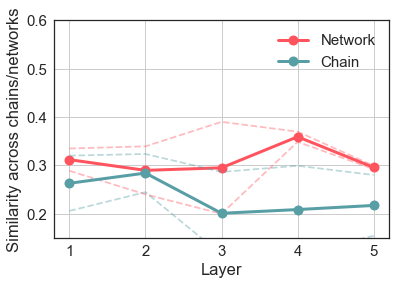

In [208]:
plt.plot(range(1,6),pd.DataFrame(d_chain2jaccard_between_n).mean(1),"o-",color="#ff545e",linewidth=3,markersize=10,label="Network")
plt.plot(range(1,6),pd.DataFrame(d_chain2jaccard_between_n).mean(1)+pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="#ff545e",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(d_chain2jaccard_between_n).mean(1)-pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="#ff545e",alpha=0.4)

plt.plot(range(1,6),pd.DataFrame(d_chain2jaccard_between).mean(1),"o-",color="#589ea5",linewidth=3,markersize=10,label="Chain")
plt.plot(range(1,6),pd.DataFrame(d_chain2jaccard_between).mean(1)+pd.DataFrame(chain2jaccard_cum).std(),"--",color="#589ea5",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(d_chain2jaccard_between).mean(1)-pd.DataFrame(chain2jaccard_cum).std(),"--",color="#589ea5",alpha=0.4)

plt.xlabel("Layer")
plt.ylabel("Similarity across chains/networks")
plt.legend()
plt.ylim(0.15,0.6)
plt.grid("on")
plt.savefig("across.pdf", dpi=600, bbox_inches='tight')

## Recall between layers

In [194]:
chain2jaccard,chain2cosine,chain2jaccard_cum,chain2cosine_cum = get_between([1,2,3,4])
chain2jaccard_n,chain2cosine_n,chain2jaccard_cum_n,chain2cosine_cum_n = get_between(chains=[1,2],type_="network")

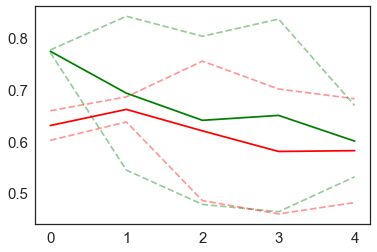

In [195]:
plt.plot(pd.DataFrame(chain2cosine_cum_n).mean(),color="green")
plt.plot(pd.DataFrame(chain2cosine_cum_n).mean()+pd.DataFrame(chain2cosine_cum_n).std(),"--",color="green",alpha=0.4)
plt.plot(pd.DataFrame(chain2cosine_cum_n).mean()-pd.DataFrame(chain2cosine_cum_n).std(),"--",color="green",alpha=0.4)

plt.plot(pd.DataFrame(chain2cosine_cum).mean(),color="red")
plt.plot(pd.DataFrame(chain2cosine_cum).mean()+pd.DataFrame(chain2cosine_cum).std(),"--",color="red",alpha=0.4)
plt.plot(pd.DataFrame(chain2cosine_cum).mean()-pd.DataFrame(chain2cosine_cum).std(),"--",color="red",alpha=0.4)

In [196]:
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

In [197]:
pd.DataFrame(chain2jaccard_cum)

,0,1,2,3,4
0,0.251111,0.250000,0.250435,0.211111,0.192308
1,0.367063,0.323529,0.279221,0.300334,0.275862
2,0.302694,0.324344,0.333333,0.333553,0.262500
3,0.370961,0.262092,0.130879,0.132812,0.141196


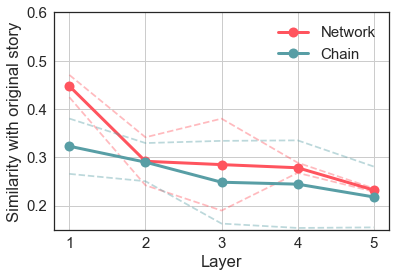

In [207]:
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum_n).mean(),"o-",color="#ff545e",linewidth=3,markersize=10,label="Network")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum_n).mean()+pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="#ff545e",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum_n).mean()-pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="#ff545e",alpha=0.4)

plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum).mean(),"o-",color="#589ea5",linewidth=3,markersize=10,label="Chain")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum).mean()+pd.DataFrame(chain2jaccard_cum).std(),"--",color="#589ea5",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum).mean()-pd.DataFrame(chain2jaccard_cum).std(),"--",color="#589ea5",alpha=0.4)

plt.xlabel("Layer")
plt.ylabel("Similarity with original story")
plt.legend()
plt.ylim(0.15,0.6)
plt.grid("on")
plt.savefig("text.pdf", dpi=600, bbox_inches='tight')

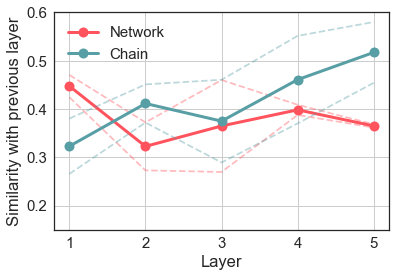

In [206]:
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_n).mean(),"o-",color="#ff545e",linewidth=3,markersize=10,label="Network")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_n).mean()+pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="#ff545e",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_n).mean()-pd.DataFrame(chain2jaccard_cum_n).std(),"--",color="#ff545e",alpha=0.4)

plt.plot(range(1,6),pd.DataFrame(chain2jaccard).mean(),"o-",color="#589ea5",linewidth=3,markersize=10,label="Chain")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard).mean()+pd.DataFrame(chain2jaccard_cum).std(),"--",color="#589ea5",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard).mean()-pd.DataFrame(chain2jaccard_cum).std(),"--",color="#589ea5",alpha=0.4)

plt.xlabel("Layer")
plt.ylabel("Similarity with previous layer")
plt.legend()
plt.ylim(0.15,0.6)
plt.grid("on")
plt.savefig("text(2).pdf", dpi=600, bbox_inches='tight')

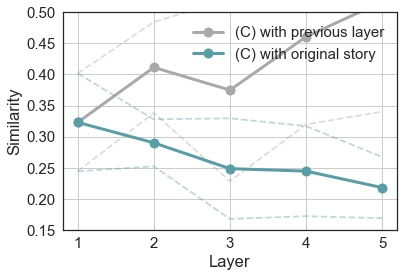

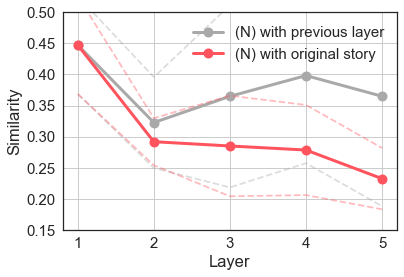

In [204]:
plt.plot(range(1,6),pd.DataFrame(chain2jaccard).mean(),"o-",color="darkgray",linewidth=3,markersize=10,label="(C) with previous layer")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard).mean()+pd.DataFrame(d).std(),"--",color="darkgray",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard).mean()-pd.DataFrame(d).std(),"--",color="darkgray",alpha=0.4)

plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum).mean(),"o-",color="#589ea5",linewidth=3,markersize=10,label="(C) with original story")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum).mean()+pd.DataFrame(d_cum).std(),"--",color="#589ea5",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum).mean()-pd.DataFrame(d_cum).std(),"--",color="#589ea5",alpha=0.4)

plt.legend()
plt.grid("on")
plt.xlabel("Layer")
plt.ylabel("Similarity")
plt.ylim(0.15,0.5)
plt.savefig("con_cum(2).pdf", dpi=600, bbox_inches='tight')

plt.show()

plt.plot(range(1,6),pd.DataFrame(chain2jaccard_n).mean(),"o-",color="darkgray",linewidth=3,markersize=10,label="(N) with previous layer")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_n).mean()+pd.DataFrame(d).std(),"--",color="darkgray",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_n).mean()-pd.DataFrame(d).std(),"--",color="darkgray",alpha=0.4)

plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum_n).mean(),"o-",color="#ff545e",linewidth=3,markersize=10,label="(N) with original story")
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum_n).mean()+pd.DataFrame(d_cum).std(),"--",color="#ff545e",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(chain2jaccard_cum_n).mean()-pd.DataFrame(d_cum).std(),"--",color="#ff545e",alpha=0.4)
plt.legend()
plt.grid("on")
plt.xlabel("Layer")
plt.ylabel("Similarity")
plt.ylim(0.15,0.5)
plt.savefig("con_cum(3).pdf", dpi=600, bbox_inches='tight')


In [202]:
d = dict()
d_cum = dict()


for r in chain2jaccard_n:
    print(r)
    d[r] = chain2jaccard_n[r] + chain2jaccard[r]
    d_cum[r] = chain2jaccard_cum_n[r] + chain2jaccard_cum[r]

0
1
2
3
4


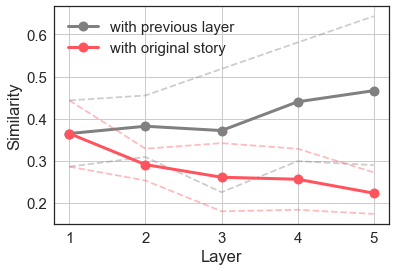

In [203]:
plt.plot(range(1,6),pd.DataFrame(d).mean(),"o-",color="gray",linewidth=3,markersize=10,label="with previous layer")
plt.plot(range(1,6),pd.DataFrame(d).mean()+pd.DataFrame(d).std(),"--",color="gray",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(d).mean()-pd.DataFrame(d).std(),"--",color="gray",alpha=0.4)


plt.plot(range(1,6),pd.DataFrame(d_cum).mean(),"o-",color="#ff545e",linewidth=3,markersize=10,label="with original story")
plt.plot(range(1,6),pd.DataFrame(d_cum).mean()+pd.DataFrame(d_cum).std(),"--",color="#ff545e",alpha=0.4)
plt.plot(range(1,6),pd.DataFrame(d_cum).mean()-pd.DataFrame(d_cum).std(),"--",color="#ff545e",alpha=0.4)

plt.legend()
plt.grid("on")
plt.xlabel("Layer")
plt.ylabel("Similarity")
plt.savefig("con_cum.png", dpi=600, bbox_inches='tight')

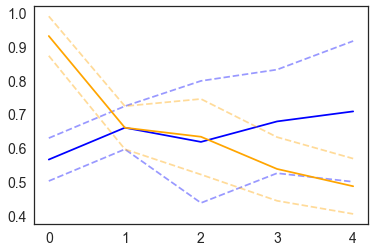

In [27]:
plt.plot(pd.DataFrame(chain2jaccard).mean(),color="blue")
plt.plot(pd.DataFrame(chain2jaccard).mean()+pd.DataFrame(chain2jaccard).std(),"--",color="blue",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard).mean()-pd.DataFrame(chain2jaccard).std(),"--",color="blue",alpha=0.4)

plt.plot(pd.DataFrame(chain2jaccard_cum).mean(),color="orange")
plt.plot(pd.DataFrame(chain2jaccard_cum).mean()+pd.DataFrame(chain2jaccard_cum).std(),"--",color="orange",alpha=0.4)
plt.plot(pd.DataFrame(chain2jaccard_cum).mean()-pd.DataFrame(chain2jaccard_cum).std(),"--",color="orange",alpha=0.4)